
# 量子近似优化算法 (QAOA)

## 简体中文 | [English](./QAOA_En.ipynb)

<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

# 准备

本文档演示 Paddle Quantum 上量子近似优化算法（QAOA，Quantum Approximate Optimization Algorithm）的工作流程 [1]。

开始之前完成准备工作：

   - 调用飞桨 paddlepaddle

   - 调用常用的库, 例如画图工具库 networkx 和 matplotlib.pyplot

   - 调用自定义函数 

In [1]:
from paddle import fluid

import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

# 背景


量子近似优化算法（QAOA，Quantum Approximate Optimization Algorithm）是可以在近期有噪中等规模（NISQ，Noisy Intermediate-Scale Quantum）量子计算机上运行且具有广泛应用前景的量子算法。例如，QAOA 可以用来处理压缩图信号和二次优化等领域常见的离散组合优化问题。这类优化问题通常可以归结为下面的数学模型：


 $$F=\max_{z_i\in\{-1,1\}} \sum_{i,j} q_{ij}(1-z_iz_j)=-\min_{z_i\in\{-1,1\}} \sum_{i,j} q_{ij}z_iz_j+ \sum_{i,j} q_{ij}. $$


其中, $z_i \in \{-1 ,1\} $ 是待求的二元参数，系数 $q_{ij}$ 是 $z_i z_j$ 的权重 (weight)。一般地，精确求解该问题对于经典计算机是 NP-hard 的，而 QAOA 被认为对近似求解这类困难问题具有潜在速度优势。

QAOA 的工作原理是把上述经典优化问题（例如组合优化问题）甚至量子优化问题（例如量子多体系统中 Ising 模型的求解）等价地转化为求解一个物理系统哈密顿量（Hamiltonian）的基态能量（对应优化问题的最优值）及其相应的基态（对应于优化问题的最优解）。接下来，我们通过图的最大割问题 （Max-Cut problem）来展示 QAOA 算法的工作流程和原理。在解决最大割问题时，QAOA 在数学形式上等价于求解一个实对角矩阵 $H$ 的最小特征值及其对应的特征向量。

和另外一种常见的变分量子特征求解器(VQE, Variational Quantum Eigensolver) 一样，QAOA 也是一种量子-经典混杂算法。 然而 QAOA 参数化量子电路的实现更简单，仅需两个可以调节参数的量子电路模块组成。


# 示例

##  1. Max-Cut 问题

图的 Max-Cut 问题可以描述为：对于一个给定的包含 $N$ 个顶点 （nodes or vertices）和 $M$ 条边 (edges) 的无向图，找到一种分割方案将图的顶点集合分割成两个无交子集合 $S$ 和 $S^\prime$，使得连接这两个顶点集合之间边的数目尽可能多。如图所示，我们考虑含4个顶点且具有环形结构的图： 

 ![ring4.png](https://release-data.cdn.bcebos.com/PIC%2FMaxCut.png) 

Max-Cut 问题建模：在做分割时，若顶点 $i$ 属于集合 $S$ 时，赋值 $z_i=1$；若顶点 $j$ 属于 $S^\prime$ 时，则令 $z_j=-1$。那么对于图的任意连接顶点 $(i, j)$ 的边则满足：若顶点属于同一集合 $S$ 或 $S^\prime$ 时，$z_iz_j=1$; 若顶点分别属于不同集合时，$z_izj=-1$。于是 Max-Cut 问题转化为如下优化问题：

$$ F=\min_{z_i\in\{-1, 1\}} z_1 z_2+z_2z_3+z_3z_4+z_4z_1.$$

这里所有 $q_{ij}$ 均设置为 1，表示每条边的权重相等。该问题的所有可行解由比特串 $ \boldsymbol{z}=z_1z_2z_3z_4 \in \{-1, 1\}^4$ 组成，而且通常需要遍历所有比特串才能得到问题的最小值（最优解）。容易看出，比特串的数目是顶点数目 $N$ 的指数级别，即 $2^N$。因此，随着顶点数目的增加，搜索的代价也会呈指数级别增加。

接下来，我们提供两种方法来预处理编码经典优化问题的图，即如何通过 Paddle Quantum 输入和可视化无权（或带权重）图：

- 方法1是通过指定图的顶点和相应的边（及其权重）
- 方法2是通过直接输入图的邻接矩阵。

In [2]:
def generate_graph(N, GRAPHMETHOD):
    """
    It plots an N-node graph which is specified by Method 1 or 2.
    
    Args:
        N: number of nodes (vertices) in the graph
        METHOD: choose which method to generate a graph
    Returns:
        the specific graph and its adjacency matrix
    """
    # Method 1 generates a graph by self-definition
    if GRAPHMETHOD == 1:
        print("Method 1 generates the graph from self-definition using EDGE description")
        graph = nx.Graph()
        graph_nodelist=range(N)
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
        graph_adjacency = nx.to_numpy_matrix(graph, nodelist=graph_nodelist)
    # Method 2 generates a graph by using its adjacency matrix directly
    elif GRAPHMETHOD == 2:
        print("Method 2 generates the graph from networks using adjacency matrix")
        graph_adjacency = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])
        graph = nx.Graph(graph_adjacency)
    else:
        print("Method doesn't exist ")

    return graph, graph_adjacency

这里指定方法1来预处理图：

- 图的顶点数目 $N=4$
- 图的输入方法 GRAPHMETHOD = 1 

注意：上述两种方法给出的图的顶点均从 $0$ 开始计数。

Method 1 generates the graph from self-definition using EDGE description
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


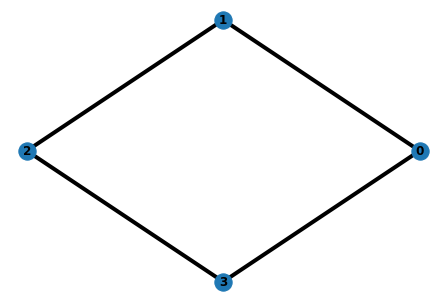

In [3]:
# number of qubits or number of nodes in the graph
N=4  
classical_graph, classical_graph_adjacency= generate_graph(N, GRAPHMETHOD=1)
print(classical_graph_adjacency)

pos = nx.circular_layout(classical_graph)
nx.draw(classical_graph, pos, width=4, with_labels=True, font_weight='bold')
plt.show()

## 2. 编码量子优化问题

接下来需要把上述经典优化问题映射为量子优化问题。利用替代关系 $z=1\rightarrow |0\rangle = \begin{bmatrix}1 \\ 0\end{bmatrix}$ 和 $z=-1\rightarrow |1\rangle = \begin{bmatrix}0 \\ 1\end{bmatrix}$, 我们把二元参数 $z_i\in\{-1, 1\}$ 对应为描述量子比特的 Pauli-Z 算符 $Z_i=\begin{bmatrix} 1 & 0\\ 0 & -1\end{bmatrix}$ 的两个本征值。于是经典优化问题里的目标函数相应地编码为一个描述系统哈密顿量的矩阵

$$H_{c}= Z_1Z_2+Z_2Z_3+Z_3Z_4+Z_4Z_1.$$

其中 $Z_iZ_{j}$ 是 tensor product 运算，表示 Pauli-Z 算符分别作用在量子比特 $i$ 和 $j$ 上，而其余的量子比特上作用单位算符 $I=\begin{bmatrix} 1 & 0\\ 0 & 1\end{bmatrix}$ ，例如 $Z_1Z_2 =Z_1\otimes Z_2\otimes I_3\otimes I_4$。经过上述操作，我们把经典优化问题转化为求解矩阵 $H_{c}$ 的最小特征值 $F$ 及其对应的向量 $|\psi\rangle$, 即

$$ F=\min_{|\psi\rangle} \langle \psi| H_c |\psi\rangle.$$

这里，$|\psi\rangle$ 记为一个模长为1的 $2^4=16$ 维复向量，$\langle \psi|$ 是其共轭转置。

Paddle Quantum 中通过函数 H_generator 完成编码任务：

In [4]:
def H_generator(N, adjacency_matrix):
    """
    This function maps the given graph via its adjacency matrix to the corresponding Hamiltiona H_c.
    
    Args:
        N: number of qubits, or number of nodes in the graph, or number of parameters in the classical problem
        adjacency_matrix:  the adjacency matrix generated from the graph encoding the classical problem
    Returns:
        the problem-based Hmiltonian H's list form generated from the graph_adjacency matrix for the given graph
    """
    H_list = []
    # Generate the Hamiltonian H_c from the graph via its adjacency matrix
    for row in range(N):
        for col in range(N):
            if adjacency_matrix[row, col] and row < col:
                # Construct the Hamiltonian in the list form for the calculation of expectation value
                H_list.append([1.0, 'z'+str(row) + ',z' + str(col)])

    return H_list

我们可以查看生成矩阵 $H_c $ 的具体形式，并且获取它的特征值信息：

In [5]:
# Convert the Hamiltonian's list form to matrix form
H_matrix = pauli_str_to_matrix(H_generator(N, classical_graph_adjacency), N)

H_diag = np.diag(H_matrix).real
H_max = np.max(H_diag)
H_min = np.min(H_diag)

print(H_diag)
print('H_max:', H_max, '  H_min:', H_min)

[ 4.  0.  0.  0.  0. -4.  0.  0.  0.  0. -4.  0.  0.  0.  0.  4.]
H_max: 4.0   H_min: -4.0


## 3. 搭建 QAOA 电路

通过交替地摆放两个参数可调的电路模块，我们得以搭建QAOA电路

$$U_x(\beta_P)U_c(\gamma_P)\dots U_x(\beta_1)U_c(\gamma_1),$$

其中放置的次数记为 $P$。具体地，模块一是由描述问题哈密顿量的矩阵生成，即

$$U_c(\gamma)=e^{-i \gamma H_c },$$

其中 $i= \sqrt{-1}$ 是虚数单位， $\gamma\in [0, \pi]$ 是可以调节的参数。模块二是

$$U_x(\beta)=e^{-i \beta H_x },$$

由描述驱动哈密顿量的另一个矩阵生成 

$$H_x =X_1+X_2+X_3+X_4. $$

$\beta\in [0, \pi]$ 也是一个可调参数，算符 $X=\begin{bmatrix} 0 & 1\\ 1 & 0\end{bmatrix}$ 是作用在量子比特上的 Pauli-X 门，例如 $X_1$ 实际数学表达式为 $X_1\otimes I_2\otimes I_3\otimes I_4$。

QAOA 电路的每一模块可以进一步分解为若干个作用在单比特和两比特上的含参的量子门，如图所示:


<!--
![QAOA.png](https://release-data.cdn.bcebos.com/PIC%2FQAOACir.png) 
-->

<img src="./figures/QAOAcircuit.png" width="600" >

其中，模块 $U_x(\beta)$ 可以分解为在每个量子比特上作用绕 $X$ 方向转动的量子门 $R_x(\beta)= e^{-i\beta X}$，而模块 $U_c(\gamma)$ 则可分解为作用在两比特上的 $ZZ$ 门 $R_{zz}(\gamma)= e^{-i\gamma Z\otimes Z}$。

此外，我们可以设置交叉放置两个模块的次数，记为 QAOA 电路的层数 $P$。于是输入

- 量子电路的初始状态
- 经典问题的邻接矩阵
- 电路比特数目
- 电路层数

构建标准的 QAOA 量子电路：

In [6]:
def circuit_QAOA(theta, adjacency_matrix, N, P):
    """
    This function constructs the parameterized QAOA circuit which is composed of P layers of two blocks:
    one block is based on the problem Hamiltonian H which encodes the classical problem,
    and the other is constructed from the driving Hamiltonian describing the rotation around Pauli X
    acting on each qubit. It outputs the final state of the QAOA circuit.
    
    Args:
        theta: parameters to be optimized in the QAOA circuit
        adjacency_matrix:  the adjacency matrix of the graph encoding the classical problem
        N: number of qubits, or equivalently, the number of parameters in the original classical problem
        P: number of layers of two blocks in the QAOA circuit
    Returns:
        the QAOA circuit
    """

    cir = UAnsatz(N)
    
    #prepare the input state in the uniform superposition of 2^N bit-strings in the computational basis
    cir.superposition_layer()
    # This loop defines the QAOA circuit with P layers of two blocks
    for layer in range(P):
        # The second and third loops construct the first block which involves two-qubit operation
        #  e^{-i\gamma Z_iZ_j} acting on a pair of qubits or nodes i and j in the circuit in each layer.
        for row in range(N):
            for col in range(N):
                if adjacency_matrix[row, col] and row < col:
                    cir.cnot([row, col])
                    cir.rz(theta[layer][0], col)
                    cir.cnot([row, col])
        # This loop constructs the second block only involving the single-qubit operation e^{-i\beta X}.
        for i in range(N):
            cir.rx(theta[layer][1], i)

    return cir

在标准 QAOA 的基础上，我们还支持对电路结构进行扩展，进一步探索 QAOA 更多可能性。例如，可以将模块二的驱动哈密顿量 $H_x$ 中的的绕单比特 X 方向转动 $R_x(\beta)$ 扩展为绕任意方向转动，即量桨中的$U3(\beta_1, \beta_2, \beta_3)$门：

In [7]:
def circuit_extend_QAOA(theta, adjacency_matrix, N, P):
    """
    This is an extended version of the QAOA circuit, and the main difference is the block constructed
    from the driving Hamiltonian describing the rotation around an arbitrary direction on each qubit.

    Args:
        theta: parameters to be optimized in the QAOA circuit
        input_state: input state of the QAOA circuit which usually is the uniform superposition of 2^N bit-strings
                     in the computational basis
        adjacency_matrix:  the adjacency matrix of the problem graph encoding the original problem
        N: number of qubits, or equivalently, the number of parameters in the original classical problem
        P: number of layers of two blocks in the QAOA circuit
    Returns:
        the extended QAOA circuit

    Note:
        If this circuit_extend_QAOA function is used to construct QAOA circuit, then we need to change the parameter layer
        in the Net function defined below from the Net(shape=[D, 2]) for circuit_QAOA function to Net(shape=[D, 4])
        because the number of parameters doubles in each layer in this QAOA circuit.
    """
    cir = UAnsatz(N)

    #prepare the input state in the uniform superposition of 2^N bit-strings in the computational basis
    cir.superposition_layer()
    for layer in range(P):
        for row in range(N):
            for col in range(N):
                if adjacency_matrix[row, col] and row < col:
                    cir.cnot([row, col])
                    cir.rz(theta[layer][0], col)
                    cir.cnot([row, col])

        for i in range(N):
            cir.u3(*theta[layer][1:], i)

    return cir

搭建 QAOA 量子电路的工作完成后，此时量子电路的输出状态为

$$|\psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)\rangle=U_x(\beta_P)U_c(\gamma_P)\dots U_x(\beta_1)U_c(\gamma_1)|+\rangle_1\dots|+\rangle_N.$$

其中每个量子比特的初始状态处于量子叠加态 $|+\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$ 。最终，我们得到量子优化问题的损失函数

$$F_P=\min_{\boldsymbol{\beta},\boldsymbol{\gamma}} \langle \psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)| H_c|\psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)\rangle.$$

因为 QAOA 是一个量子-经典混杂算法，所以搭建完成 QAOA 电路且得到相应的损失函数后，我们可以进一步利用经典的优化算法寻找最优参数 $\boldsymbol{\beta},\boldsymbol{\gamma}$，从而形成一个完整的闭环网络。

下面的函数给出了通过 Paddle Quantum 搭建的完整 QAOA 网络：

In [8]:
class Net(fluid.dygraph.Layer):
    """
    It constructs the net for QAOA which combines the  QAOA circuit with the classical optimizer which sets rules
    to update parameters described by theta introduced in the QAOA circuit.

    """
    def __init__(
        self,
        shape,
        param_attr=fluid.initializer.Uniform(low=0.0, high=np.pi, seed=1024),
        dtype="float64",
    ):
        super(Net, self).__init__()

        self.theta = self.create_parameter(
            shape=shape, attr=param_attr, dtype=dtype, is_bias=False
        )

    def forward(self, adjacency_matrix, N, P, METHOD):
        """
        This function constructs the loss function for the QAOA circuit.

        Args:
            adjacency_matrix: the adjacency matrix generated from the graph encoding the classical problem
            N: number of qubits
            P: number of layers
            METHOD: which version of QAOA is chosen to solve the problem, i.e., standard version labeled by 1 or
            extended version by 2.
        Returns:
            the loss function for the parameterized QAOA circuit and the circuit itself
        """
        
        # Generate the problem_based quantum Hamiltonian H_problem based on the classical problem in paddle
        H_problem = H_generator(N, adjacency_matrix)

        # The standard QAOA circuit: the function circuit_QAOA is used to construct the circuit, indexed by METHOD 1.
        if METHOD == 1:
            cir = circuit_QAOA(self.theta, adjacency_matrix, N, P)
        # The extended QAOA circuit: the function circuit_extend_QAOA is used to construct the net, indexed by METHOD 2.
        elif METHOD == 2:
            cir = circuit_extend_QAOA(self.theta, adjacency_matrix, N, P)
        else:
            raise ValueError("Wrong method called!")

        cir.run_state_vector()
        loss = cir.expecval(H_problem)

        return loss, cir

## 4. 训练网络

我们开始训练整个 QAOA 网络，即通过优化参数向量 $\boldsymbol{\beta}=(\beta_1,\beta_2,\beta_3,\beta_4)$ 和 $\boldsymbol{\gamma}=(\gamma_1,\gamma_2,\gamma_3, \gamma_4)$ 来达到求解 $H_c$ 最小特征值的目的。

与经典机器学习算法一样，首先设置 QAOA 网络里的超参数:

- 电路比特数目 N
- 电路的层数 P
- 迭代次数 ITR
- 学习步长 LR

In [9]:
N = 4 # number of qubits, or number of nodes in the graph
P = 4 # number of layers 
ITR = 120  # number of iteration steps
LR = 0.1  # learning rate

然后，灵活调用：

- 量子电路初始状态：通过调用`superposition_layer()`使每个量子比特处于相干叠加态 $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$
- 采用标准 QAOA （记为 METHOD=1）或者扩展 QAOA （记为 METHOD = 2）
- 经典优化器 Adam optimizer 

最后，训练模型并保存结果：

In [10]:
def Paddle_QAOA(classical_graph_adjacency, N, P, METHOD, ITR, LR):
    """
    This is the core function to run QAOA.

     Args:
         classical_graph_adjacency: adjacency matrix to describe the graph which encodes the classical problem
         N: number of qubits (default value N=4)
         P: number of layers of blocks in the QAOA circuit (default value P=4)
         METHOD: which version of the QAOA circuit is used: 1, standard circuit (default); 2, extended circuit
         ITR: number of iteration steps for QAOA (default value ITR=120)
         LR: learning rate for the gradient-based optimization method (default value LR=0.1)
     Returns:
         the optimized QAOA circuit
    """
    with fluid.dygraph.guard():
        # Construct the net or QAOA circuits based on the standard modules
        if METHOD == 1:
            net = Net(shape=[P, 2])
        # Construct the net or QAOA circuits based on the extended modules
        elif METHOD == 2:
            net = Net(shape=[P, 4])
        else:
            raise ValueError("Wrong method called!")

        # Classical optimizer
        opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())

        # Gradient descent loop
        summary_iter, summary_loss = [], []
        for itr in range(1, ITR + 1):
            loss, cir = net(
                classical_graph_adjacency, N, P, METHOD
            )
            loss.backward()
            opt.minimize(loss)
            net.clear_gradients()

            if itr % 10 == 0:
                print("iter:", itr, "  loss:", "%.4f" % loss.numpy())
            summary_loss.append(loss[0][0].numpy())
            summary_iter.append(itr)

        theta_opt = net.parameters()[0].numpy()
        print("Optmized parameters theta:\n", theta_opt)
        
        os.makedirs("output", exist_ok=True)
        np.savez("./output/summary_data", iter=summary_iter, energy=summary_loss)

    return cir

调用模型训练结果，输出得到的最优参数向量 $\boldsymbol{\beta}^*$ 和 $\boldsymbol{\gamma}^*$，并且将 QAOA 的输出结果和真实结果进行比较：

Method 1 generates the graph from self-definition using EDGE description
iter: 10   loss: -3.8531
iter: 20   loss: -3.9626
iter: 30   loss: -3.9845
iter: 40   loss: -3.9944
iter: 50   loss: -3.9984
iter: 60   loss: -3.9996
iter: 70   loss: -3.9999
iter: 80   loss: -4.0000
iter: 90   loss: -4.0000
iter: 100   loss: -4.0000
iter: 110   loss: -4.0000
iter: 120   loss: -4.0000
Optmized parameters theta:
 [[0.24726127 0.53087308]
 [0.94954664 1.9974811 ]
 [1.14545257 2.27267827]
 [2.98845718 2.84445401]]


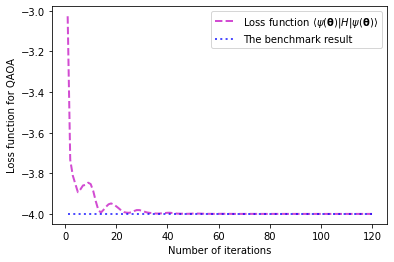

In [11]:
classical_graph, classical_graph_adjacency = generate_graph(N, 1)

opt_cir = Paddle_QAOA(classical_graph_adjacency, N =4, P=4, METHOD=1, ITR=120, LR=0.1)

# Load the data of QAOA
x1 = np.load('./output/summary_data.npz')

H_min = np.ones([len(x1['iter'])]) * H_min

# Plot loss
loss_QAOA, = plt.plot(x1['iter'], x1['energy'], \
                                        alpha=0.7, marker='', linestyle="--", linewidth=2, color='m')
benchmark, = plt.plot(x1['iter'], H_min, alpha=0.7, marker='', linestyle=":", linewidth=2, color='b')
plt.xlabel('Number of iterations')
plt.ylabel('Loss function for QAOA')

plt.legend(handles=[
    loss_QAOA,
    benchmark
],
    labels=[
            r'Loss function $\left\langle {\psi \left( {\bf{\theta }} \right)} '
            r'\right|H\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $',
            'The benchmark result',
    ], loc='best')

# Show the plot
plt.show()


## 5. 解码量子答案

当求得损失函数 $\langle \psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)| H_{\rm Cut}|\psi(\boldsymbol{\beta},\boldsymbol{\gamma}, P)\rangle$ 的最小值以及相对应的一组参数 $(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*)$ 后，我们的任务还没有完成。为了进一步求得 Max-Cut 问题的解，需要从 QAOA 输出的量子态 

$$|\psi(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*, P)\rangle=\sum_{i=1}^{2^4}\lambda_i |\boldsymbol{x}_i\rangle$$

中解码出经典优化问题的答案。上式中  $\boldsymbol{x}_i=x_1x_2x_3 x_4\in \{0, 1\}^4$，对应着经典问题的一个可行解。物理上，解码量子态需要对量子态进行测量，然后统计测量结果的概率分布：
                 
$$ p(\boldsymbol{x})=|\langle \boldsymbol{x}|\psi(\boldsymbol{\beta}^*,\boldsymbol{\gamma}^*,P)\rangle|^2.$$
              

多数情况下，某个比特串出现的概率越大，意味着其对应的 Max-Cut 问题最优解的可能性越大。

此外，Paddle Quantum 提供了查看 QAOA 量子电路输出状态的测量结果概率分布的函数：

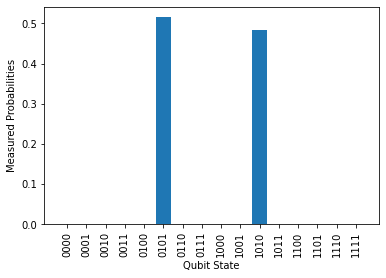

In [12]:
with fluid.dygraph.guard():
    # Measure the output state of the QAOA circuit for 1024 shots by default
    prob_measure = opt_cir.measure(plot=True)

最后，再次利用参数代换 $|x \rangle\rightarrow z=2x-1\in\{-1, 1\}$，可以从量子答案中解码得到 Max-Cut 问题的可行解。 此时，记 $z_i=-1$ 的顶点属于集合 $S^\prime$ 以及 $z_j=1$ 的顶点属于集合 $S$，这两个顶点集合之间存在的边就是该图的一个可能得最大割方案。 

选取测量结果中出现几率最大的比特串，然后将其映射回经典解，并且画出对应的最大割方案：

- 蓝色顶点属于集合 $S$
- 红色顶点属于集合 $S^\prime$
- 虚线表示被割的边

The output bitstring: ['0101']


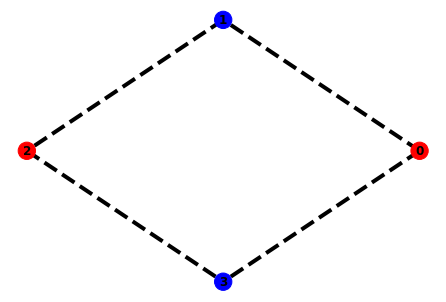

In [13]:
# Find the max value in measured probability of bitstrings
max_prob = max(prob_measure.values())
# Find the bitstring with max probability
solution_list = [result[0] for result in prob_measure.items() if result[1] == max_prob]
print("The output bitstring:", solution_list)

# Draw the graph representing the first bitstring in the solution_list to the MaxCut-like problem
head_bitstring = solution_list[0]

node_cut = ["blue" if head_bitstring[node] == "1" else "red" for node in classical_graph]

edge_cut = [
    "solid" if head_bitstring[node_row] == head_bitstring[node_col] else "dashed"
    for node_row, node_col in classical_graph.edges()
    ]
nx.draw(
        classical_graph,
        pos,
        node_color=node_cut,
        style=edge_cut,
        width=4,
        with_labels=True,
        font_weight="bold",
)
plt.show()

# 参考文献

[1] [Farhi, E., Goldstone, J. & Gutmann, S. A Quantum Approximate Optimization Algorithm. arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)